In [4]:
#######################################################################
#####                                                             #####
#####     SPARSE IDENTIFICATION OF NONLINEAR DYNAMICS (SINDy)     #####
#####     Application to the Lotka-Volterra system                #####
#####                                                             #####
#######################################################################

"""

This small example illustrates the identification of a nonlinear
dynamical system using the data-driven approach SINDy with constraints
by Loiseau & Brunton (submitted to JFM Rapids).

Note: The sklearn python package is required for this example.
----

Contact: loiseau@mech.kth.se

"""


#--> Import standard python libraries
from math import *
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#--> Import some features of scipy to simulate the systems
#    or for matrix manipulation.
from scipy.integrate import odeint
from scipy.linalg import block_diag

#--> Import the PolynomialFeatures function from the sklearn
#    package to easily create the library of candidate functions
#    that will be used in the sparse regression problem.
from sklearn.preprocessing import PolynomialFeatures

#--> Import the sparse identification python package containing
#    the class to create sindy estimators.
import sparse_identification as sp
from sparse_identification.utils import derivative as spder
from sparse_identification.solvers import hard_threshold_lstsq_solve
from sparse_identification.utils import derivative
from sparse_identification import sindy

#--> Defines various functions used in this script.

def Lotka_Volterra(x0, r, a, time):
    def dynamical_system(y,t):
        dy = np.zeros_like(y)
        for i in range(4):
            dy[i] = r[i]*y[i]*(1-a[i][0]*y[0]-a[i][1]*y[1]-a[i][2]*y[2]-a[i][3]*y[3])
        return dy

    x = odeint(dynamical_system,x0,time,mxstep=0)
    dt = time[1]-time[0]
    xdot = spder(x,dt)

    return x, xdot

def constraints(library):

    """

    This function illustrates how to impose some
    user-defined constraints for the sparse identification.

    Input
    -----

    library : library object used for the sparse identification.

    Outputs
    -------

    C : two-dimensional numpy array.
        Constraints to be imposed on the regression coefficients.

    d : one-dimensional numpy array.
        Value of the constraints.

    """

    #--> Recover the number of input and output features of the library.
    m = library.n_input_features_
    n = library.n_output_features_

    #--> Initialise the user-defined constraints matrix and vector.
    #    In this example, two different constraints are imposed.
    C = np.zeros((2, m*n))
    d = np.zeros((2,1))

    #--> Definition of the first constraint:
    #    In the x-equation, one imposes that xi[2] = -xi[1]
    #    Note: xi[0] corresponds to the bias, xi[1] to the coefficient
    #    for x(t) and xi[2] to the one for y(t).
    C[0, 1] = 1
    C[0, 2] = 1

    #--> Definition of the second constraint:
    #    In the y-equation, one imposes that xi[1] = 28
    #    Note: the n+ is because the coefficient xi[1] for
    #    the y-equation is the n+1th entry of the regression
    #    coefficients vector.
    C[1, n+1] = 1
    d[1] = 28

    return C, d

def Identified_Model(y, t, library, estimator) :

    '''
    Simulates the model from Sparse identification.

    Inputs
    ------

    library: library object used in the sparse identification
             (e.g. poly_lib = PolynomialFeatures(degree=3) )

    estimator: estimator object obtained from the sparse identification

    Output
    ------

    dy : numpy array object containing the derivatives evaluated using the
         model identified from sparse regression.

    '''

    dy = np.zeros_like(y)

    lib = library.fit_transform(y.reshape(1,-1))
    Theta = block_diag(lib, lib, lib, lib)
    dy = Theta.dot(estimator.coef_)

    return dy

def perturb_parameters(p, mean=0, stdev=0):
    return p + np.random.normal(mean, stdev, size=p.shape)

In [5]:
true_r = np.array([1, 0.72, 1.53, 1.27])
true_a = np.array([[1, 1.09, 1.52, 0], 
                  [0, 1, 0.44, 1.36], 
                  [2.33, 0, 1, 0.47], 
                  [1.21, 0.51, 0.35, 1]])

## Infinity norm between trajectories inferred from perturbing both parameters `r` and `a` via 0-mean Gaussian (it might be worth it to perturb from 1-mean exponential distribution as in Vano)

In [ ]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 100, 100)
noise_level = np.logspace(-5, -1, 100)
diff = []
initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    while total < 5:
        x0 = np.random.uniform(-2, 2, 4)
        x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
        if np.max(np.abs(x_temp)) > 1 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
        total += 1
        initials[i].append(x0)

for noise in noise_level:
    noise_diff = []
    print(noise)
    i = 0
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            r_p = r + np.random.normal(0, noise, r.shape)
            a_p = a + np.random.normal(0, noise, a.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r_p, a_p, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
        noise_diff.append(inf_norm)
        i += 1
    diff.append(np.mean(noise_diff, axis=0))

In [ ]:
plt.plot(np.log10(noise_level), np.log10(diff))
plt.title('Infinity Norm between Trajectories - $t \in [0, 5]$')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.savefig('r_a.png')
plt.show()

## Infinity norm between trajectories inferred from perturbing one of each parameters `r` and `a` via 0-mean Gaussian

In [9]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 100, 100)
noise_level = np.logspace(-5, -1, 100)
initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    while total < 5:
        x0 = np.random.uniform(-2, 2, 4)
        x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
        if np.max(np.abs(x_temp)) > 1 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
        total += 1
        initials[i].append(x0)
        
r_diff = []
a_diff = []

for noise in noise_level:
    print(noise)
    i = 0
    noise_diff = []
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            r_p = r + np.random.normal(0, noise, r.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r_p, a, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
        noise_diff.append(inf_norm)
        i += 1
    r_diff.append(np.mean(noise_diff, axis=0))
    
    i = 0
    noise_diff = []
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            a_p = a + np.random.normal(0, noise, a.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r, a_p, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
        noise_diff.append(inf_norm)
        i += 1
    a_diff.append(np.mean(noise_diff, axis=0))

/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1e-05


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


1.09749876549e-05
1.20450354026e-05
1.32194114847e-05
1.4508287785e-05
1.59228279334e-05
1.74752840001e-05
1.91791026167e-05
2.10490414451e-05
2.31012970008e-05
2.53536449397e-05
2.78255940221e-05
3.05385550883e-05
3.35160265094e-05
3.67837977183e-05
4.0370172586e-05
4.43062145758e-05
4.86260158007e-05
5.33669923121e-05
5.85702081806e-05
6.42807311728e-05
7.05480231072e-05
7.74263682681e-05
8.49753435909e-05
9.32603346883e-05
0.00010235310219
0.000112332403298
0.000123284673944
0.000135304777458
0.000148496826225
0.000162975083462
0.000178864952906
0.000196304065004
0.000215443469003
0.000236448941265
0.00025950242114
0.000284803586844
0.000312571584969
0.000343046928631
0.000376493580679
0.000413201240012
0.000453487850813
0.000497702356433
0.000546227721768
0.000599484250319
0.000657933224658
0.000722080901839
0.000792482898354
0.000869749002618
0.000954548456662
0.00104761575279
0.0011497569954
0.00126185688307
0.00138488637139
0.00151991108295
0.0016681005372
0.0018307382803
0.0020

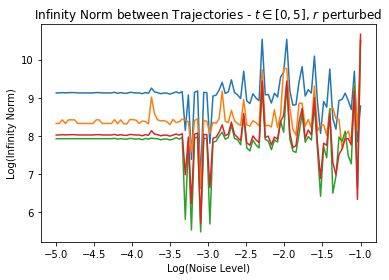

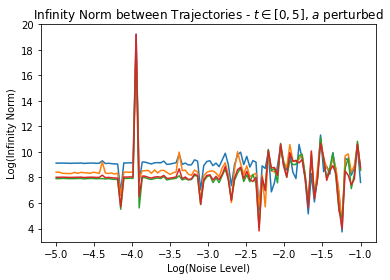

In [16]:
plt.title('Infinity Norm between Trajectories - $t \in [0, 5]$, $r$ perturbed')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.plot(np.log10(noise_level), np.log10(r_diff), label="$r$ perturbed")
plt.savefig('r_b1.png')
plt.show()

plt.title('Infinity Norm between Trajectories - $t \in [0, 5]$, $a$ perturbed')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.plot(np.log10(noise_level), np.log10(a_diff), label="$a$ perturbed")
plt.savefig('r_b2.png')
plt.show()

## Attempt to infer coefficient distance by perturbing parameters `r` and `a` by 0-mean Gaussian

In [14]:
def make_coefficients(r, a, num_terms):
    '''
    Turn Lotka-Volterra coefficients into sklearn PolynomialFeatures coefficients for
    3D system. 
    '''
    num_vars = 4
    coeffs = np.zeros((num_vars, num_terms))
    for i in range(num_vars):
        coeffs[i, i+1] = r[i]
    coeffs[0, [4, 5, 6, 7]] = a[0]
    coeffs[1, [5, 8, 9, 10]] = a[1]
    coeffs[2, [6, 9, 11, 12]] = a[2]
    coeffs[3, [7, 10, 12, 13]] = a[3]
    
    return coeffs.ravel()

r = true_r.copy()
a = true_a.copy()
true_coeffs = make_coefficients(r, a, 15)
t = np.linspace(0, 100, 100)
noise_level = np.logspace(-5, -1, 100)
dist, sparsity = [], []

initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    while total < 5:
        x0 = np.random.uniform(-2, 2, 4)
        x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
        if np.max(np.abs(x_temp)) > 1 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
        total += 1
        initials[i].append(x0)

for noise in noise_level:
    print(noise)
    i = 0
    noise_dist, noise_sparsity = [], []
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            r_p = r + np.random.normal(0, noise, r.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r_p, a, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        coefs = shols.coef_
        noise_dist.append(np.linalg.norm(coefs - true_coeffs))
        noise_sparsity.append(np.count_nonzero(coefs))
        i += 1
    dist.append(np.mean(noise_dist))
    sparsity.append(np.mean(noise_sparsity))

/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1e-05


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


1.09749876549e-05
1.20450354026e-05
1.32194114847e-05
1.4508287785e-05
1.59228279334e-05
1.74752840001e-05
1.91791026167e-05
2.10490414451e-05
2.31012970008e-05
2.53536449397e-05
2.78255940221e-05
3.05385550883e-05
3.35160265094e-05
3.67837977183e-05
4.0370172586e-05
4.43062145758e-05
4.86260158007e-05
5.33669923121e-05
5.85702081806e-05
6.42807311728e-05
7.05480231072e-05
7.74263682681e-05
8.49753435909e-05
9.32603346883e-05
0.00010235310219
0.000112332403298
0.000123284673944
0.000135304777458
0.000148496826225
0.000162975083462
0.000178864952906
0.000196304065004
0.000215443469003
0.000236448941265
0.00025950242114
0.000284803586844
0.000312571584969
0.000343046928631
0.000376493580679
0.000413201240012
0.000453487850813
0.000497702356433
0.000546227721768
0.000599484250319
0.000657933224658
0.000722080901839
0.000792482898354
0.000869749002618
0.000954548456662
0.00104761575279
0.0011497569954
0.00126185688307
0.00138488637139
0.00151991108295
0.0016681005372
0.0018307382803
0.0020

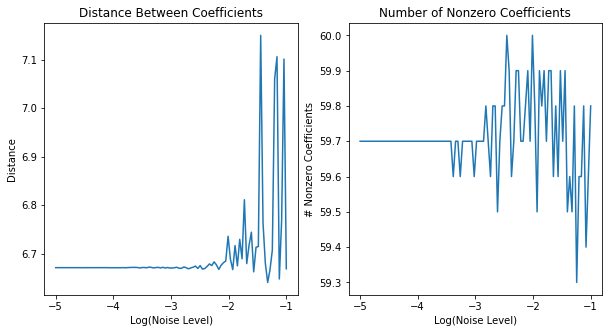

In [15]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.log10(noise_level), dist)
ax[0].set_title('Distance Between Coefficients')
ax[0].set_xlabel('Log(Noise Level)')
ax[0].set_ylabel('Distance')
ax[1].plot(np.log10(noise_level), sparsity)
ax[1].set_title('Number of Nonzero Coefficients')
ax[1].set_xlabel('Log(Noise Level)')
ax[1].set_ylabel('# Nonzero Coefficients')
plt.savefig('r_c.png')
plt.show()

# Other stuff below

In [ ]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 100, 100)
noise_level = np.logspace(-5, -1, 100)
diff = []
initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    while total < 5:
        x0 = np.random.uniform(-2, 2, 4)
        x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
        if np.max(np.abs(x_temp)) > 1 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
        total += 1
        initials[i].append(x0)

for noise in noise_level:
    noise_diff = []
    print(noise)
    i = 0
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            r_p = r + np.random.normal(0, noise, r.shape)
            a_p = a + np.random.normal(0, noise, a.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r_p, a_p, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
        noise_diff.append(inf_norm)
        i += 1
    diff.append(np.mean(noise_diff, axis=0))

In [ ]:
def simulate_parameter_perturbance(mean, stdev, max_trials=5, verbose=False):
    #--> Sets the parameters for the Lotka-Volterra system.
    r = true_r.copy()
    a = true_a.copy()

    t = np.linspace(0, 100, 500)

    trials = 0

    inferred_coeffs = []
    r, a = perturb_parameters(true_r, mean, stdev), perturb_parameters(true_a, mean, stdev)
    
    if (verbose):
        print("Initializing 5 trials with mean {} and stdev {}".format(mean, stdev))
    
    while trials < max_trials:
        x0 = np.random.rand(4)
        x, dx = Lotka_Volterra(x0, r, a, t)
        
        # enforcing limitation on trajectory of system
        if (np.max(np.abs(x)) > 10) or (np.any(np.isnan(x))):
            continue
        
        poly_lib = PolynomialFeatures(degree=2, include_bias=True)
        lib = poly_lib.fit_transform(x)
        Theta = block_diag(lib, lib, lib, lib)
        n_lib = poly_lib.n_output_features_

        b = dx.flatten(order='F')
        A = Theta

        C, d = constraints(poly_lib)

        estimator = sp.sindy(l1=0.01, solver='lstsq')
        estimator.fit(A, b)
        coeffs = hard_threshold_lstsq_solve(A, b)
        
        # strictly enforcing some limitation on the size of inferred coefficients
        if (np.max(np.abs(coeffs)) > 10):
            continue
        
        inferred_coeffs.append(coeffs)

        trials += 1
        if (trials % 50 == 0):
            print(trials)
        
    return inferred_coeffs

In [ ]:
'''
Calculates difference in perturbed parameters from true parameters using L2 norm
'''
def calculate_parameter_difference(mean, stdev, max_trials=5):
    inferred = simulate_parameter_perturbance(0, 0, max_trials)
    inferred_true_parameters = sum(inferred)/len(inferred)
    
    perturbed = simulate_parameter_perturbance(mean, stdev, max_trials)
    inferred_perturbed_parameters = sum(perturbed)/len(perturbed)
    
    return np.linalg.norm(inferred_perturbed_parameters - inferred_true_parameters)

In [ ]:
calculate_parameter_difference(0, 0.001)

In [ ]:
parameter_l2_norm = []
stdevs = np.logspace(0, 10, 50)
for stdev in stdevs:
    print("Starting stdev of {}".format(stdev))
    diff = None
    while (not diff):
        try:
            diff = calculate_parameter_difference(0, stdev, max_trials=50)
        except Exception as e:
            pass
    parameter_l2_norm.append(diff)

In [ ]:
%matplotlib inline

plt.plot(stdevs[:25], parameter_l2_norm)
plt.xscale('log')
plt.xlabel('$\sigma$')
plt.ylabel('$L_{2}$')